In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_ancillary
import jsm_visualize
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg

In [3]:
def differential(rat, rat_bins, rat_binsize): 
    N = np.histogram(rat, bins=rat_bins)[0]
    return N/rat_binsize

In [4]:
def SHMF(mass_mat, min_mass, max_mass, Nbins):

    lgMh_bins = np.linspace(min_mass, max_mass, Nbins)
    lgMh_binsize = lgMh_bins[1] - lgMh_bins[0]
    lgMh_bincenters = 0.5 * (lgMh_bins[1:] + lgMh_bins[:-1])

    counts = np.apply_along_axis(differential, 1, mass_mat, rat_bins=lgMh_bins, rat_binsize=lgMh_binsize) # the accretion mass of the surviving halos
    counts_ave = np.average(counts, axis=0)
    counts_std = np.std(counts, axis=0)
    SHMF_werr = np.array([counts_ave, counts_std])

    return lgMh_bincenters, SHMF_werr

In [5]:
plt.style.use('../../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [6]:
S0 = jsm_ancillary.load_sample("../../data/fiducial/S0_sample.h5")
S0 = S0.sort_values(by="host_z50")

In [7]:
final_mass = np.log10(jsm_ancillary.make_matrix(S0, "sat_mass")/1e12)

acc_mass = np.log10(jsm_ancillary.make_matrix(S0, "sat_acc_mass")/1e12)

In [8]:
fb = np.log10(jsm_ancillary.make_matrix(S0, "sat_mass")/jsm_ancillary.make_matrix(S0, "sat_acc_mass"))

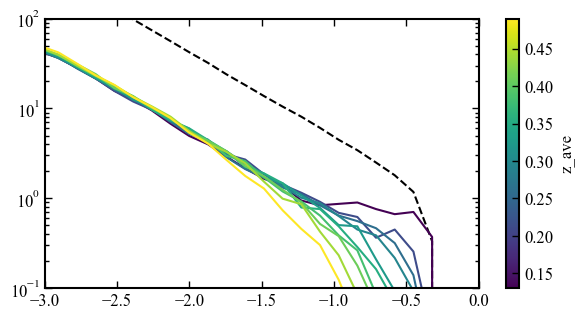

In [9]:
cmap = cm.viridis
Nsplit = 10

z_ave = [np.average(zsamp) for zsamp in np.split(np.log10(1 + S0.host_z50), Nsplit)]
norm = plt.Normalize(vmin=np.min(z_ave), vmax=np.max(z_ave))

fig, ax = plt.subplots(figsize=(double_textwidth, single_textwidth))

x_u, y_u = SHMF(acc_mass, -3.1, 0, 25)
ax.plot(x_u, y_u[0], c="k", ls="--")


for i, sample in enumerate(np.split(final_mass, Nsplit)):
    x, y = SHMF(sample, -3.1, 0, 25)
    ax.plot(x, y[0], c=cmap(norm(z_ave[i])))

ax.set_yscale("log")
ax.set_ylim(1e-1, 1e2)
ax.set_xlim(-3, 0)

# --- add colorbar ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)  # <- tell it which axes to attach to
cbar.set_label("z_ave")

plt.show()


In [10]:
# make a N(macc/M0) vs host halo mass plot (no correlation)
# make a N(m/M0) vs host halo mass plot (strong correlation)

In [11]:
S30 = jsm_ancillary.load_sample("../../data/fiducial/S30_sample.h5")

In [12]:
final_mass = jsm_ancillary.make_matrix(S30, "sat_mass")
acc_mass = jsm_ancillary.make_matrix(S30, "sat_acc_mass")
acc_order = jsm_ancillary.make_matrix(S30, "sat_acc_order")

host_mass = S30.host_mass.values
limit = np.array(host_mass * 0.0001)
host_z50 = S30.host_z50.values

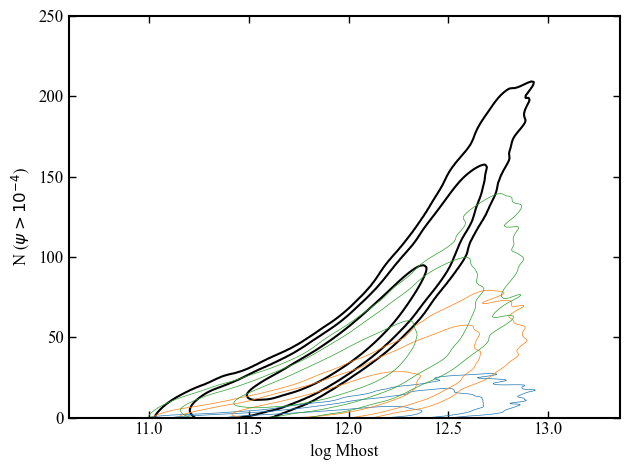

In [13]:
final_mask = final_mass > limit[:, None]
countz = final_mask.sum(axis=1)

sns.kdeplot(x=np.log10(host_mass), y=countz, levels=levelz, linewidths=1.5, color="k")

for i in range(3,0,-1):
    order_mask = (acc_order == i)
    full_mask = final_mask & order_mask
    countz = full_mask.sum(axis=1)
    sns.kdeplot(x=np.log10(host_mass), y=countz, levels=levelz, linewidths=0.5)

plt.xlabel("log Mhost")
plt.ylabel("N ($\\psi > 10^{-4}$)")
plt.ylim(0, 250)
plt.tight_layout()
plt.show()

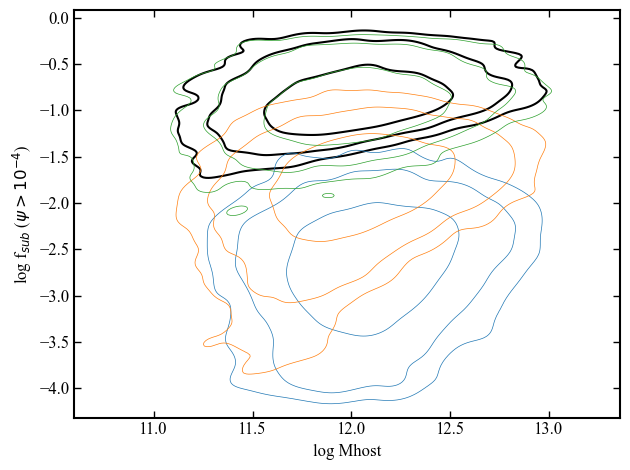

In [14]:
final_mask = final_mass > limit[:, None]
masked_final_mass = np.where(final_mask, final_mass, np.nan)
f_sub = np.nansum(masked_final_mass, axis=1)/host_mass

sns.kdeplot(x=np.log10(host_mass), y=np.log10(f_sub), levels=levelz, linewidths=1.5, color="k")

for i in range(3,0,-1):
    order_mask = (acc_order == i)
    full_mask = final_mask & order_mask
    masked_final_mass = np.where(full_mask, final_mass, np.nan)
    f_sub = np.nansum(masked_final_mass, axis=1)/host_mass
    sns.kdeplot(x=np.log10(host_mass), y=np.log10(f_sub), levels=levelz, linewidths=0.5)

plt.xlabel("log Mhost")
plt.ylabel("log f$_{sub}$ ($\\psi > 10^{-4}$)")
plt.tight_layout()
plt.show()

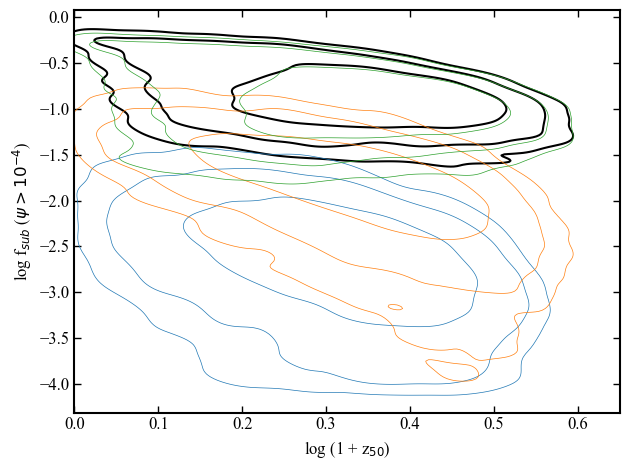

In [15]:
final_mask = final_mass > limit[:, None]
masked_final_mass = np.where(final_mask, final_mass, np.nan)
f_sub = np.nansum(masked_final_mass, axis=1)/host_mass

sns.kdeplot(x=np.log10(1+host_z50), y=np.log10(f_sub), levels=levelz, linewidths=1.5, color="k")

for i in range(3,0,-1):
    order_mask = (acc_order == i)
    full_mask = final_mask & order_mask
    masked_final_mass = np.where(full_mask, final_mass, np.nan)
    f_sub = np.nansum(masked_final_mass, axis=1)/host_mass
    sns.kdeplot(x=np.log10(1+host_z50), y=np.log10(f_sub), levels=levelz, linewidths=0.5)

plt.xlabel("log (1 + z$_{50}$)")
plt.ylabel("log f$_{sub}$ ($\\psi > 10^{-4}$)")

plt.xlim(0, 0.65)
plt.tight_layout()
plt.show()

In [16]:
S0 = jsm_ancillary.load_sample("../../data/fiducial/S0_sample.h5")

In [17]:
final_mass = jsm_ancillary.make_matrix(S0, "sat_mass")
acc_mass = jsm_ancillary.make_matrix(S0, "sat_acc_mass")
acc_order = jsm_ancillary.make_matrix(S0, "sat_acc_order")

host_mass = S0.host_mass.values
limit = np.array(host_mass * 0.0001)
host_z50 = S0.host_z50.values

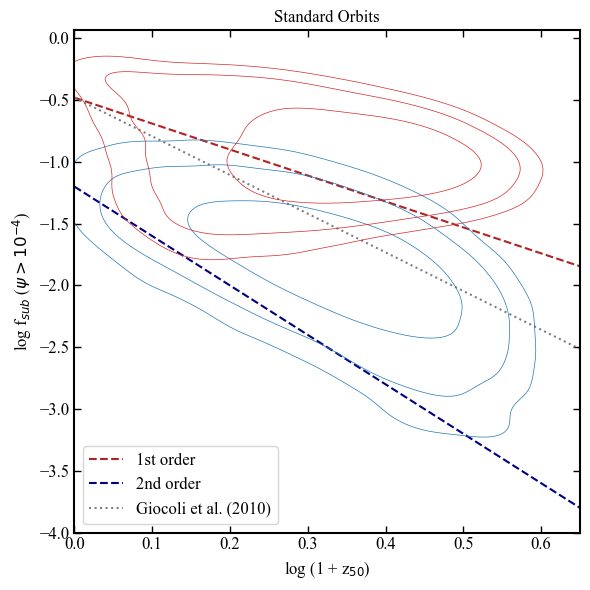

In [18]:
final_mask = final_mass > limit[:, None]
masked_final_mass = np.where(final_mask, final_mass, np.nan)
f_sub = np.nansum(masked_final_mass, axis=1)/host_mass
colors = ["C3", "C0"]

zsmooth = np.linspace(0, 0.7, 50)

plt.figure(figsize=(6,6))

plt.plot(zsmooth, -0.48+(-2.1*zsmooth), color="firebrick", ls="--", label="1st order")
plt.plot(zsmooth, -1.2+(-4*zsmooth), color="navy", ls="--", label="2nd order")
plt.plot(zsmooth, -0.48+(-3.13*zsmooth), color="grey", ls=":", label="Giocoli et al. (2010)")

for i in range(2,0,-1):
    order_mask = (acc_order == i)
    full_mask = final_mask & order_mask
    masked_final_mass = np.where(full_mask, final_mass, np.nan)
    f_sub = np.nansum(masked_final_mass, axis=1)/host_mass
    sns.kdeplot(x=np.log10(1+host_z50), y=np.log10(f_sub), levels=levelz, linewidths=0.5, color=colors[i-1], bw_adjust=1.5)

plt.legend(loc=3)
plt.xlabel("log (1 + z$_{50}$)")
plt.ylabel("log f$_{sub}$ ($\\psi > 10^{-4}$)")
plt.title("Standard Orbits")
plt.xlim(0, 0.65)
plt.ylim(-4)
plt.tight_layout()
plt.show()

In [19]:
S0 = jsm_ancillary.load_sample("../../data/fiducial/S0uniform_sample.h5")

In [20]:
final_mass = jsm_ancillary.make_matrix(S0, "sat_mass")
acc_mass = jsm_ancillary.make_matrix(S0, "sat_acc_mass")
acc_order = jsm_ancillary.make_matrix(S0, "sat_acc_order")

host_mass = S0.host_mass.values
limit = np.array(host_mass * 0.0001)
host_z50 = S0.host_z50.values

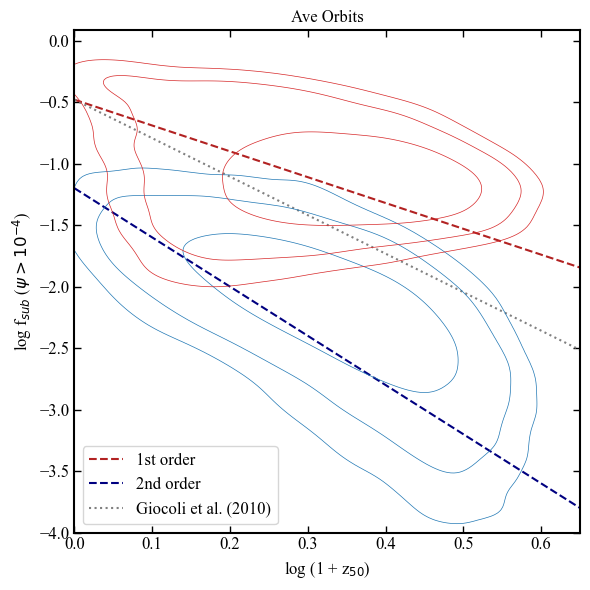

In [24]:
final_mask = final_mass > limit[:, None]
masked_final_mass = np.where(final_mask, final_mass, np.nan)
f_sub = np.nansum(masked_final_mass, axis=1)/host_mass
colors = ["C3", "C0"]

zsmooth = np.linspace(0, 0.7, 50)


plt.figure(figsize=(6,6))

plt.plot(zsmooth, -0.48+(-2.1*zsmooth), color="firebrick", ls="--", label="1st order")
plt.plot(zsmooth, -1.2+(-4*zsmooth), color="navy", ls="--", label="2nd order")
plt.plot(zsmooth, -0.48+(-3.13*zsmooth), color="grey", ls=":", label="Giocoli et al. (2010)")

for i in range(2,0,-1):
    order_mask = (acc_order == i)
    full_mask = final_mask & order_mask
    masked_final_mass = np.where(full_mask, final_mass, np.nan)
    f_sub = np.nansum(masked_final_mass, axis=1)/host_mass
    sns.kdeplot(x=np.log10(1+host_z50), y=np.log10(f_sub), levels=levelz, linewidths=0.5, color=colors[i-1], bw_adjust=1.5)

plt.legend(loc=3)
plt.xlabel("log (1 + z$_{50}$)")
plt.ylabel("log f$_{sub}$ ($\\psi > 10^{-4}$)")
plt.title("Ave Orbits")
plt.ylim(-4)
plt.xlim(0, 0.65)
plt.tight_layout()
plt.show()

In [ ]:
og = jsm_visualize.Tree_Vis(file="../../../StellarHalo/data/uniform/tree_1238_evo_og.npz", merger_crit=-2, fesc=0.2, scatter=False, verbose=False)
uni = jsm_visualize.Tree_Vis(file="../../../StellarHalo/data/uniform/tree_1238_evo.npz", merger_crit=-2, fesc=0.2, scatter=False, verbose=False)

In [ ]:
og.plot_acc_tree()

In [ ]:
uni.plot_acc_tree()

In [ ]:
og.make_orbit_movie(video_path="og.mp4")

In [ ]:
uni.make_orbit_movie(video_path="uni.mp4")